# Import libraries

In [75]:
import torch
import sklearn
import numpy as np
import pandas as pd
from torch import nn
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

# Device Agonistic Code

In [76]:
device = "cuda" if torch.cuda.is_available() is True else "cpu"
device

'cuda'

# Dataset Preparing and Preprocessing

## Making a binary classification dataset

In [77]:
n_samples = 1000
X, y = make_circles(n_samples, noise=0.03, random_state=42)

In [78]:
# print the first 5 data
X[:5], y[:5]

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0], dtype=int64))

In [79]:
X.shape, y.shape

((1000, 2), (1000,))

In [80]:
# Turn numpy array into PyTorch Tensors
X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)

In [81]:
# Turn the dataset into pandas dataframe format
# circles = pd.DataFrame({"X1": X[:,0], "X2": X[:,1], "y": y})

## Data Visualisation

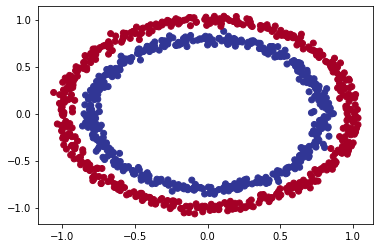

In [82]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

## Data Splitting

In [83]:
X.shape, y.shape

(torch.Size([1000, 2]), torch.Size([1000]))

In [84]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=42)

In [85]:
X_train.shape, y_train.shape

(torch.Size([800, 2]), torch.Size([800]))

In [86]:
X_test.shape, y_test.shape

(torch.Size([200, 2]), torch.Size([200]))

# Hyperparameters

In [87]:
# Hyperparameters
input_dim = len(X[0])
hidden_dim = 10
out_dim = 1
learning_rate = 0.01
epochs = 100

# Feedforward Neural Network Model

## Model Structure

In [88]:
class DnnForCircleClassification(nn.Module):
    def __init__(self, input_dim, hidden_dim, out_dim):
        super().__init__()
        self.layers = nn.Sequential(
        nn.Linear(input_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, out_dim),
        nn.Sigmoid()
            )
    def forward(self, x):
        return self.layers(x) 

In [89]:
model = DnnForCircleClassification(input_dim, hidden_dim, out_dim)

In [90]:
model

DnnForCircleClassification(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=1, bias=True)
    (3): Sigmoid()
  )
)

In [91]:
model.state_dict()

OrderedDict([('layers.0.weight',
              tensor([[ 0.2507, -0.5746],
                      [-0.5629,  0.3762],
                      [-0.4345, -0.5312],
                      [ 0.5091, -0.4056],
                      [ 0.5051, -0.3570],
                      [ 0.1904, -0.1603],
                      [-0.2349,  0.2385],
                      [ 0.4900, -0.4329],
                      [-0.4654, -0.3486],
                      [ 0.5634, -0.3772]])),
             ('layers.0.bias',
              tensor([-0.2862, -0.1945,  0.2755, -0.0746, -0.4160, -0.2709,  0.2266,  0.6101,
                       0.5861, -0.2804])),
             ('layers.2.weight',
              tensor([[ 0.2196,  0.2306, -0.1872,  0.1080,  0.0745,  0.0142, -0.1148, -0.0722,
                        0.1299, -0.2748]])),
             ('layers.2.bias', tensor([-0.1355]))])

## Loss Function and Optimizer

In [92]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), learning_rate)

# Training

## Train with GPU

In [93]:
X_train.shape

torch.Size([800, 2])

In [94]:
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)
model.to(device)
next(model.parameters()).to(device)

Parameter containing:
tensor([[ 0.2507, -0.5746],
        [-0.5629,  0.3762],
        [-0.4345, -0.5312],
        [ 0.5091, -0.4056],
        [ 0.5051, -0.3570],
        [ 0.1904, -0.1603],
        [-0.2349,  0.2385],
        [ 0.4900, -0.4329],
        [-0.4654, -0.3486],
        [ 0.5634, -0.3772]], device='cuda:0', requires_grad=True)

In [95]:
# Create epoch list and loss list for visialisation
epoch_list = []
train_loss_list = []
test_loss_list = []

In [96]:
for epoch in range(1000):
    model.train()
    
    # Foward Propagation
    y_preds = model(X_train)
    
    # Compute loss|
    loss = criterion(torch.squeeze(y_preds), y_train)
    
    # Clear grads
    optimizer.zero_grad()
    
    # Compute grads
    loss.backward()
    
    # Update parameters
    optimizer.step()
    
    # Testing
    model.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_preds = model(X_test)
        # 2. Caculate loss/accuracy
        test_loss = criterion(torch.squeeze(test_preds), y_test)

    # Save current epoch and loss
    epoch_list.append(epoch)
    train_loss_list.append(loss.item())
    test_loss_list.append(test_loss.item())
    # Print training loss while training
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}; Training Loss: {loss.item()}; Testing Loss: {test_loss.item()}")

Epoch: 0; Training Loss: 0.6971679329872131; Testing Loss: 0.697825014591217
Epoch: 10; Training Loss: 0.6866353750228882; Testing Loss: 0.689116358757019
Epoch: 20; Training Loss: 0.6785299777984619; Testing Loss: 0.6818751096725464
Epoch: 30; Training Loss: 0.6695485711097717; Testing Loss: 0.6732181310653687
Epoch: 40; Training Loss: 0.6583393812179565; Testing Loss: 0.662348747253418
Epoch: 50; Training Loss: 0.6442023515701294; Testing Loss: 0.6503393650054932
Epoch: 60; Training Loss: 0.6265072226524353; Testing Loss: 0.6361647844314575
Epoch: 70; Training Loss: 0.6055434942245483; Testing Loss: 0.6174662113189697
Epoch: 80; Training Loss: 0.5812632441520691; Testing Loss: 0.5974230170249939
Epoch: 90; Training Loss: 0.5540730953216553; Testing Loss: 0.5730000734329224
Epoch: 100; Training Loss: 0.5252370834350586; Testing Loss: 0.546261191368103
Epoch: 110; Training Loss: 0.4950388967990875; Testing Loss: 0.5196881890296936
Epoch: 120; Training Loss: 0.46430128812789917; Testing

In [97]:
torch.squeeze(y_preds)[:5]

tensor([0.9993, 0.0058, 0.0022, 0.0029, 0.9958], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [98]:
y_train[:5]

tensor([1., 0., 0., 0., 1.], device='cuda:0')

In [99]:
y_train.shape

torch.Size([800])

Text(0.5, 1.0, 'Training loss curve')

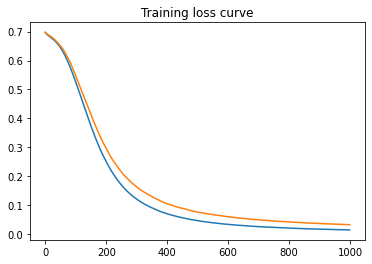

In [100]:
# Plot the loss curves
# plt.figure(figsize=(6,12))
plt.plot(epoch_list, train_loss_list, label="Training Loss")
plt.plot(epoch_list, test_loss_list, label="Testing Loss")
plt.title("Training loss curve")

# Evaluating on Training Set

In [101]:
model.cpu()
next(model.parameters()).cpu()
X_train = X_train.cpu()
y_train = y_train.cpu()
X_test = X_test.cpu()
y_test = y_test.cpu()
y_preds= y_preds.cpu()

In [102]:
len(y_preds)

800

In [103]:
for i in range(len(y_preds)):
    y_preds[i] = 1 if y_preds[i] >=0.5 else 0

In [104]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [105]:
accuracy_fn(y_train, y_preds.squeeze())

100.0

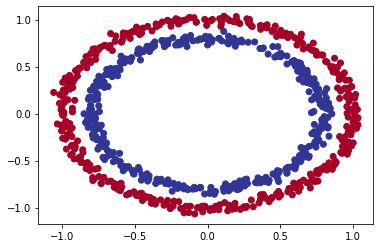

In [106]:
plt.scatter(X_train[:, 0].detach().numpy(), X_train[:, 1].detach().numpy(), c=y_preds.detach().numpy(), cmap=plt.cm.RdYlBu)

# Predicting

In [107]:
model.eval()
with torch.inference_mode():
    test_preds = model(X_test)
test_preds[:5]

tensor([[0.9997],
        [0.0096],
        [0.9979],
        [0.0023],
        [0.9973]])

In [108]:
preds = torch.clone(test_preds)

In [109]:
for i in range(len(preds)):
    preds[i] = 1 if preds[i] >=0.5 else 0

In [110]:
accuracy_fn(y_test, preds.squeeze())

100.0

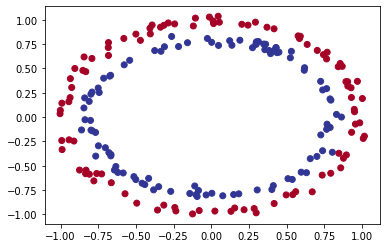

In [111]:
plt.scatter(X_test[:, 0].detach().numpy(), X_test[:, 1].detach().numpy(), c=preds.detach().numpy(), cmap=plt.cm.RdYlBu)

# Saving

In [113]:
# 保存模型
import os
# Creating the save path
PATH = "./models"
MODEL_NAME = "deep_neural_network.pth"
MODEL_SAVE_PATH = PATH+'/'+MODEL_NAME
torch.save(obj=model.state_dict(),f=MODEL_SAVE_PATH)